Rendering 73 frames at 25 fps (≈ 2.9s) …
Silent video rendered. Adding audio …
MP4 with synced audio ready. Generating GIF...
GIF generated successfully! Displaying below:


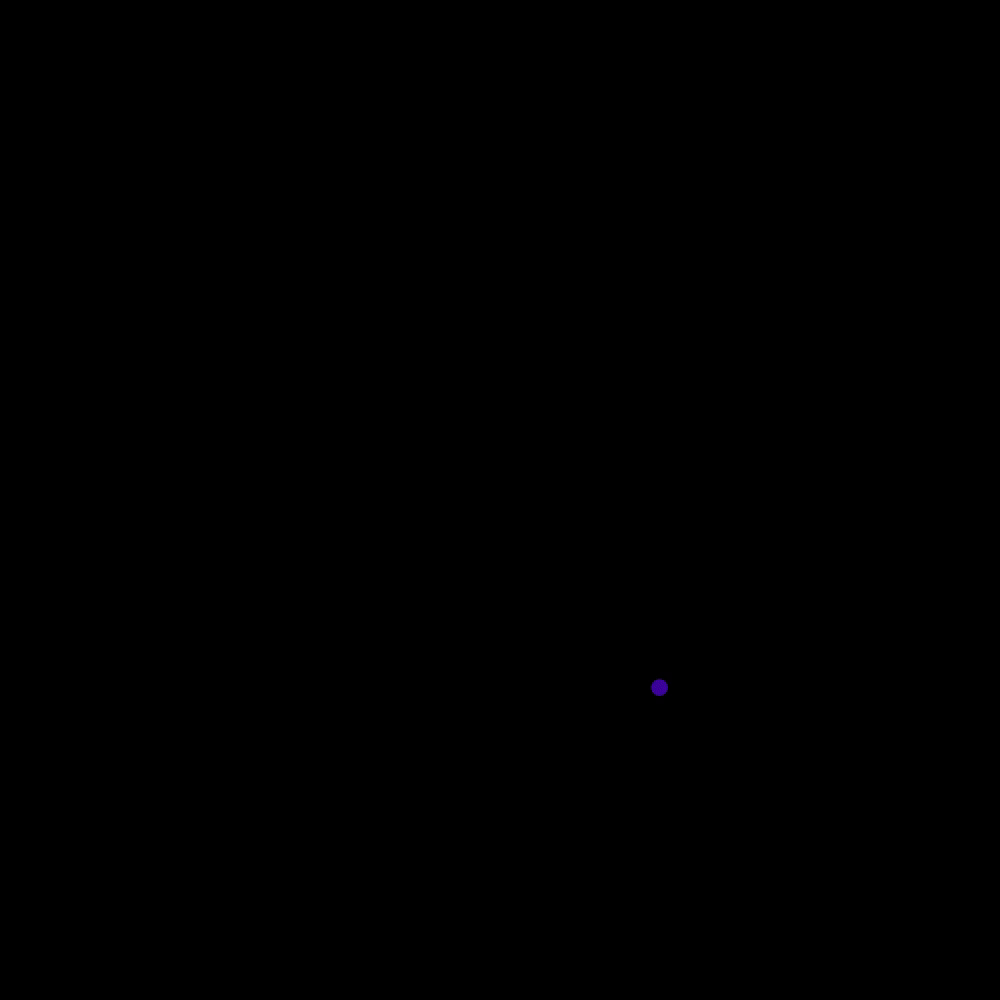

In [1]:
# ==========================================
# ANIMATED 3D PITCH TRAJECTORY — 1x LOOP & GIF
# • No axes, labels, grid, or text (except node label)
# • Live dynamic frequency label (e.g., "1.3k")
# • 1× loop (original duration)
# • Renders synced MP4 and identical GIF
# ==========================================

import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Video, Image, display
from scipy.io import wavfile
import subprocess
import os
from scipy.interpolate import interp1d

# ── 1. Download Audio ─────────────────────────────────────────────────────────

url = (
    "https://raw.githubusercontent.com/ronniross/biosignal-translator/main/taxonomy/"
    "cellular-life/eukarya/animalia/chordata/vertebrata/avians/passeriformes/passeri/"
    "parulidae/parkesia/parkesia-noveboracensis-northern-waterthrush/"
    "northern-naterthrush-1.wav"
)
file_name = "northern-waterthrush.wav"
if not os.path.exists(file_name):
    os.system(f"wget -q '{url}' -O {file_name}")

# ── 2. Audio Analysis ────────────────────────────────────────────────────────

y, sr = librosa.load(file_name, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
hop_length = 512

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, hop_length=hop_length)
S_db = librosa.power_to_db(S, ref=np.max)
times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=hop_length)
frequencies = librosa.mel_frequencies(n_mels=256, fmin=50.0, fmax=sr / 2)

peak_freq_indices = np.argmax(S_db, axis=0)
peak_freqs = frequencies[peak_freq_indices]
peak_amps  = np.max(S_db, axis=0)

# ── 3. Map Frequency → Fixed 3D Position ─────────────────────────────────────

f_min, f_max = frequencies.min(), frequencies.max()
norm_f = (peak_freqs - f_min) / (f_max - f_min + 1e-9)   # 0..1

# Spiral layout
angle  = norm_f * 4 * np.pi          # 2 full rotations across freq range
radius = 0.3 + norm_f * 0.7          # 0.3 .. 1.0

x_pos = radius * np.cos(angle)
y_pos = radius * np.sin(angle)
z_pos = peak_amps                    # dB value (≤ 0)

# Silence mask
mask  = peak_amps > -55
t_raw = times[mask]
x_raw = x_pos[mask]
y_raw = y_pos[mask]
z_raw = z_pos[mask]
f_raw = peak_freqs[mask]
a_raw = peak_amps[mask]

# ── 4. Build data arrays (1x Duration) ──────────────────────────────────────

t_data = t_raw
x_data = x_raw
y_data = y_raw
z_data = z_raw
f_data = f_raw
a_data = a_raw
total_dur = duration

# Target ~25 fps for smooth visuals
FPS    = 25
n_frames = int(total_dur * FPS)

frame_times = np.linspace(0, total_dur, n_frames)

def safe_interp(arr, src_t, dst_t):
    f = interp1d(src_t, arr, kind='linear', bounds_error=False,
                 fill_value=(arr[0], arr[-1]))
    return f(dst_t)

xi = safe_interp(x_data, t_data, frame_times)
yi = safe_interp(y_data, t_data, frame_times)
zi = safe_interp(z_data, t_data, frame_times)
fi = safe_interp(f_data, t_data, frame_times)
ai = safe_interp(a_data, t_data, frame_times)

# ── 5. Build Figure — pure black, no axes ────────────────────────────────────

plt.style.use('default')
fig = plt.figure(figsize=(10, 10), facecolor='#000000')
ax  = fig.add_subplot(111, projection='3d', facecolor='#000000')

# Strip EVERYTHING visible except the data
ax.set_facecolor('#000000')
ax.xaxis.pane.fill = False;  ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.fill = False;  ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.fill = False;  ax.zaxis.pane.set_edgecolor('none')
ax.grid(False)
ax.xaxis._axinfo["grid"]["color"] = (0,0,0,0)
ax.yaxis._axinfo["grid"]["color"] = (0,0,0,0)
ax.zaxis._axinfo["grid"]["color"] = (0,0,0,0)
ax.set_axis_off()
ax.set_xlabel('');  ax.set_ylabel('');  ax.set_zlabel('')
ax.set_title('')

xl = max(abs(xi)) + 0.1
yl = max(abs(yi)) + 0.1
ax.set_xlim(-xl, xl)
ax.set_ylim(-yl, yl)
ax.set_zlim(min(zi) - 3, 2)

# ── 6. Plot elements: ghost + glow + core + burst dot + Text Label ─────────

GHOST_LEN = 120
GLOW_LEN  = 50
CORE_LEN  = 15

ghost, = ax.plot([], [], [], lw=5,  color='#4400cc', alpha=0.07)
glow,  = ax.plot([], [], [], lw=3,  color='#9933ff', alpha=0.22)
core,  = ax.plot([], [], [], lw=1.5,color='#ffffff', alpha=0.85)

# The leading point trail
dot = ax.scatter([], [], [], s=120, c=[], cmap='plasma',
                 vmin=f_data.min(), vmax=f_data.max(),
                 depthshade=False, zorder=10)

# The current frame amplitude burst
flare = ax.scatter([], [], [], s=[], c=[], cmap='hot',
                   vmin=0, vmax=1, alpha=0.5, depthshade=False, zorder=9)

# Live Frequency Text Label
# ADDED zdir=None HERE so it defaults to facing the camera upright
freq_text = ax.text(0, 0, 0, "", zdir=None, color='white', fontsize=18, weight='bold', ha='center', va='bottom', zorder=15)

# ── 7. Per-frame Update Function ───────────────────────────────────────────

def update(num):
    n = max(num, 1)

    g0 = max(0, n - GHOST_LEN)
    e0 = max(0, n - GLOW_LEN)
    c0 = max(0, n - CORE_LEN)

    ghost.set_data(xi[g0:n], yi[g0:n])
    ghost.set_3d_properties(zi[g0:n])

    glow.set_data(xi[e0:n], yi[e0:n])
    glow.set_3d_properties(zi[e0:n])

    core.set_data(xi[c0:n], yi[c0:n])
    core.set_3d_properties(zi[c0:n])

    # Leading trail colored by frequency
    dot._offsets3d = (xi[c0:n], yi[c0:n], zi[c0:n])
    dot.set_array(fi[c0:n])

    # Amplitude burst
    loud = np.clip((ai[n-1] + 55) / 55, 0, 1)   # 0=silent, 1=loud
    burst_size = loud ** 2 * 800
    flare._offsets3d = ([xi[n-1]], [yi[n-1]], [zi[n-1]])
    flare.set_array([loud])
    flare.set_sizes([burst_size])

    # Dynamic Frequency Text Label (e.g., '1.3k')
    if loud > 0.05:  # Only display the label if sound is playing
        freq_text.set_text(f"{fi[n-1]/1000:.1f}k")
    else:
        freq_text.set_text("")

    # Position the text slightly above the active node
    freq_text.set_position((xi[n-1], yi[n-1]))

    # ADDED zdir=None HERE to ensure it doesn't snap back to 'z' mode upon updating
    freq_text.set_3d_properties(zi[n-1] + 3.0, zdir=None)

    # Smooth, slow camera sweep (120 degrees across the single duration)
    ax.view_init(elev=28, azim=num * (120 / n_frames))

    return ghost, glow, core, dot, flare, freq_text

# ── 8. Render silent video ──────────────────────────────────────────────────

silent_path = 'bird_silent.mp4'
print(f"Rendering {n_frames} frames at {FPS} fps (≈ {total_dur:.1f}s) …")
ani = animation.FuncAnimation(
    fig, update, frames=n_frames, interval=1000/FPS, blit=False
)
ani.save(silent_path, writer='ffmpeg', fps=FPS,
         savefig_kwargs={'facecolor': '#000000'},
         extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-crf', '18'])
plt.close(fig)
print("Silent video rendered. Adding audio …")

# ── 9. Mux video + audio (1x loop) ──────────────────────────────────────────

final_path = 'bird_trajectory_final.mp4'
cmd = (
    f"ffmpeg -y "
    f"-i {silent_path} "
    f"-i {file_name} "
    f"-c:v copy -c:a aac -b:a 192k "
    f"-shortest "
    f"{final_path} -loglevel quiet"
)
os.system(cmd)
print("MP4 with synced audio ready. Generating GIF...")

# ── 10. Generate GIF ────────────────────────────────────────────────────────

gif_path = 'bird_trajectory_final.gif'
# High-quality palette generation to preserve the 1000x1000 size natively
gif_cmd = (
    f"ffmpeg -y -i {final_path} "
    f"-vf \"split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse\" "
    f"-loop 0 {gif_path} -loglevel quiet"
)
os.system(gif_cmd)
print("GIF generated successfully! Displaying below:")

# ── 11. Display Outputs ─────────────────────────────────────────────────────

# Display the Video
display(Video(final_path, embed=True, html_attributes="controls autoplay loop"))

# Display the GIF
display(Image(filename=gif_path))